In [1]:
using Random
using Distributions
using LinearAlgebra
include("../Inversion/IPS.jl")
include("../Inversion/Plot.jl")
include("../Inversion/RWMCMC.jl")
include("../Inversion/SMC.jl")
include("../Inversion/KalmanInversion.jl")
include("../Inversion/GMGD.jl")

GMGD_Run (generic function with 3 methods)

In [2]:
mutable struct Setup_Param{IT<:Int}
    θ_names::Array{String,1}
    N_θ::IT
    N_y::IT
end

function Setup_Param(N_θ::IT, N_y::IT) where {IT<:Int}
    return Setup_Param(["θ"], N_θ, N_y)
end

Setup_Param

## Gaussian Mixture Kalman Inversion

## Circle shape likelihood function

We will explore the question with the following inverse problem 

$$
\begin{align*}
y = 
\Bigl(
\theta_{(1)}^2 +  \theta_{(2)}^2
\Bigr)
+\eta
\qquad 
y = 1
\qquad
\Sigma_{\eta} = 
\begin{bmatrix}
0.3^2 
\end{bmatrix} 
\end{align*}
$$


We focus on the noninformative uniform prior, and hence we are sampling $e^{-\frac{1}{2}(y-\theta_{(1)}^2 -  \theta_{(2)}^2)^T\Sigma_{\eta}^{-1}(y-\theta_{(1)}^2 -  \theta_{(2)}^2)}$.
     

In [3]:
function func_G(θ)
    θ₁, θ₂ = θ
    return [θ₁^2 + θ₂^2;]
end


function log_circle_shape(θ, y, ση)
    θ₁, θ₂ = θ
    return -(y[1] - func_G(θ)[1])^2/(2ση^2) 
end

function V_circle_shape(θ, y, ση)
    θ₁, θ₂ = θ    
    V   = (y[1] - θ₁^2 - θ₂^2)^2/(2ση^2)
    ∇V  = [ 2(y[1] - θ₁^2 - θ₂^2)*(-2θ₁)/(2ση^2) ;   2(y[1] - θ₁^2 - θ₂^2)*(-2θ₂)/(2ση^2)]
    ∇²V = [ (-4*(y[1] - θ₁^2 - θ₂^2) + 8θ₁^2)/(2ση^2)   8*θ₁*θ₂/(2ση^2);   8*θ₁*θ₂/(2ση^2)   (-4*(y[1] - θ₁^2 - θ₂^2) + 8θ₂^2)/(2ση^2)] 
    return V, ∇V, ∇²V
    
end

function forward(s_param::Setup_Param, θ)
    return func_G(θ)
end



forward (generic function with 1 method)

In [4]:
using ForwardDiff
using KernelDensity
function circle_shape(μ0 = [0.0;0.0];Run_GMKI = false, Run_MCMC = false, Run_Fisher_Rao = false, Run_GMGD = false)

    σ0 = 1.0
    Σ0 = [σ0^2 0.0;0.0  σ0^2]

    ση = 0.3
    Σ_η = [ση^2;;]
    y = [1.0;]

    # compute posterior distribution by MCMC
    
    if Run_MCMC
        step_length = 0.1
        N_iter = 10^7
        us = RWMCMC_Run(θ->log_circle_shape(θ, y, ση), μ0, step_length, N_iter);
        everymarker = 100
        fig, ax = PyPlot.subplots(ncols=1, sharex=false, sharey=true, figsize=(6,4))
        n_burn_in, n_end = div(N_iter, 10), N_iter
        ax.scatter(us[n_burn_in:everymarker:n_end, 1], us[n_burn_in:everymarker:n_end, 2], s = 0.1, label="MCMC")
        ax.legend()
    end
    
    

    N_y, N_θ = 1, 2
    # compute posterior distribution by GMKI
    update_freq = 1
    N_modes = 10
    θ0_w  = ones(N_modes)/N_modes
    θ0_mean, θθ0_cov  = zeros(N_modes, N_θ), zeros(N_modes, N_θ, N_θ)


    Random.seed!(111);
    for m = 1:N_modes
        θ0_mean[m, :]    .= rand(MvNormal(zeros(N_θ), Σ0)) + μ0
        θθ0_cov[m, :, :] .= Σ0
    end

    s_param = Setup_Param(N_θ, N_y)

    
    if Run_GMKI
        N_iter = 30
        adapt_α = false
        trunc_α = 1.0e-3
        Δt = 5e-1
        mixture_power_sampling_method = "random-sampling" # "random-sampling-derivatives"
        gmkiobj = GMKI_Run(s_param, forward, θ0_w, θ0_mean, θθ0_cov, y, Σ_η, Δt, update_freq, N_iter; unscented_transform = "modified-2n+1", adapt_α = adapt_α, trunc_α = trunc_α, mixture_power_sampling_method = "random-sampling")
    end
    
    if Run_GMGD
        N_iter = 1000
        Δt = 1.0e-2
        gaussain_mixture_V = θ -> V_circle_shape(θ, y, ση)
        T = N_iter * Δt
        metric = "Fisher-Rao"
        update_covariance = true
        
        expectation_method = "unscented_transform"


        N_ens = 1
        gmgdobj = GMGD_Run(
            gaussain_mixture_V, 
            N_iter,
            T,
            metric,
            update_covariance, 
            θ0_w, θ0_mean, θθ0_cov,
            expectation_method,
            N_ens)
        
    end
    
    
    if Run_Fisher_Rao
        s_param = Setup_Param(N_θ, N_y)
        N_ens  = 100
        method  = "Wasserstein-Fisher-Rao"
        preconditioner = false             # true
        Δt, N_iter = 1e-2, 10^3
        
        logρ = θ ->log_circle_shape(θ, μ0, σ0, y, ση)
        
        function compute_∇logρ(s_param, θ)
            return logρ(θ), ForwardDiff.gradient(logρ, θ)
        end   
        θ0 = Array(rand(MvNormal(μ0, Σ0), N_ens)')   
        kernel_param = nothing
        ipsobj = IPS_Run(s_param, compute_∇logρ, θ0, N_ens, Δt, N_iter, method, preconditioner, kernel_param)
        
        
        fig, ax = PyPlot.subplots(ncols=1, sharex=false, sharey=true, figsize=(6,4))
        n_burn_in, n_end = div(N_iter, 10)*N_ens, N_iter*N_ens
        θs = vcat(ipsobj.θ...)[n_burn_in:n_end, :]
        ax.scatter(θs[:, 1], θs[:, 2], s = 0.1, label=method)
        ax.legend()
    end
    
    

    # visualization 
    x_min, x_max = -4.0, 4.0
    y_min, y_max = -4.0, 4.0
    Nx, Ny = 2000, 2000
    xx = LinRange(x_min, x_max, Nx)
    yy = LinRange(y_min, y_max, Ny)
    X,Y = repeat(xx, 1, Ny), repeat(yy, 1, Nx)' 
    
    Z_ref = copy(X)
    for i = 1:Nx
        for j = 1:Ny
            temp = [X[i,j] ; Y[i,j]]
            Z_ref[i,j] = exp(log_circle_shape(temp, y, ση))
        end
    end
    Z_ref /= ( sum(Z_ref)*(xx[2]-xx[1])*(yy[2]-yy[1]) )
    
    
    
    
    
    # Visualize different iterations
    for iter_percentage  in [0, 0.25, 0.5, 0.75, 1]
        nrows, ncols = 1, 3
        fig, ax = PyPlot.subplots(nrows=nrows, ncols=ncols, sharex=false, sharey=false, figsize=(15,5))
        
        color_lim = (minimum(Z_ref), maximum(Z_ref))
        ax[1].pcolormesh(X, Y, Z_ref, cmap="viridis", clim=color_lim)
        ax[1].set_xlabel(L"\theta_{(1)}")
        ax[1].set_ylabel(L"\theta_{(2)}")
        ax[1].set_title("Reference")
        
        
        if Run_Fisher_Rao
            
            θs = ipsobj.θ[end]
            
            kernel = kde(θs)
            Z = pdf(kernel, xx, yy)
            Z /= (sum(Z)*(xx[2]-xx[1])*(yy[2]-yy[1]) )
            ax[4].pcolormesh(X, Y, Z, cmap="viridis", clim=color_lim)
            ax[4].scatter([θs[:,1];], [θs[:,2];], marker="o", color="b", s=2, alpha=0.2)
        
            ax[4].set_xlabel(L"\theta_{(1)}")
            ax[4].set_ylabel(L"\theta_{(2)}")
            ax[4].set_title("BDLS-KL")
            
            @info "Fisher-Rao L₁ error = ", sum(abs.(Z - Z_ref))/sum(abs.(Z_ref))
        end
        
        if Run_MCMC
            kernel = kde(us[n_burn_in:n_end, :])
            Z = pdf(kernel, xx, yy)
            ax[5].pcolormesh(X, Y, Z, cmap="viridis", clim=color_lim)
            ax[5].set_xlabel(L"\theta_{(1)}")
            ax[5].set_ylabel(L"\theta_{(2)}")
            ax[5].set_title("MCMC")
            
            @info "MCMC L₁ error = ", sum(abs.(Z - Z_ref))/sum(abs.(Z_ref))
        end
        
        
        
    
        if Run_GMKI
            iter = floor(Int64, iter_percentage*(length(gmkiobj.θ_mean)-1)) + 1
            Z = zeros(N_modes, Nx, Ny)
            # plot GMKI results 
            for i =1:N_modes
                gmki_θ_mean = gmkiobj.θ_mean[iter][i, :]
                gmki_θθ_cov = gmkiobj.θθ_cov[iter][i, :, :]
                _,_, Z[i, :, :] = Gaussian_2d(gmki_θ_mean, gmki_θθ_cov, Nx, Ny, x_min, x_max, y_min, y_max) 
                Z[i,:,:] *= exp(gmkiobj.logθ_w[iter][i])

            end
            Z_GMKI = sum(Z, dims=1)[1,:,:]
            Z_GMKI /= (sum(Z_GMKI)*(xx[2]-xx[1])*(yy[2]-yy[1]) )
            ax[2].pcolormesh(X, Y, Z_GMKI, cmap="viridis", clim=color_lim)
            @info "GMKI L₁ error = ", sum(abs.(Z_GMKI - Z_ref))/sum(abs.(Z_ref))


            # linestyles = ["o"; "x"; "s"]
            for i =1:N_modes
                gmki_θ_mean = gmkiobj.θ_mean[iter][i, :]
                gmki_θθ_cov = gmkiobj.θθ_cov[iter][i, :, :]
                linestyle = "o" 
                ax[2].scatter([gmki_θ_mean[1];], [gmki_θ_mean[2];], marker=linestyle, color="C"*string(i), facecolors=(linestyle=="x" ? nothing : "none"))
            end
        
            ax[2].set_xlabel(L"\theta_{(1)}")
            ax[2].set_ylabel(L"\theta_{(2)}")
            ax[2].set_title("GMKI")
        end
        
        if Run_GMGD
            iter = floor(Int64, iter_percentage*(length(gmgdobj.θ_mean)-1)) + 1
            
            Z = zeros(N_modes, Nx, Ny)
            # plot GMGD results 
            for i =1:N_modes
                gmgd_θ_mean = gmgdobj.θ_mean[iter][i, :]
                gmgd_θθ_cov = gmgdobj.θθ_cov[iter][i, :, :]
                _,_, Z[i, :, :] = Gaussian_2d(gmgd_θ_mean, gmgd_θθ_cov, Nx, Ny, x_min, x_max, y_min, y_max) 
                Z[i,:,:] *= exp(gmgdobj.logθ_w[iter][i])

            end
            Z_GMGD = sum(Z, dims=1)[1,:,:]
            Z_GMGD /= (sum(Z_GMGD)*(xx[2]-xx[1])*(yy[2]-yy[1]) )
            
            ax[3].pcolormesh(X, Y, Z_GMGD, cmap="viridis", clim=color_lim)
            @info "GMGD L₁ error = ", sum(abs.(Z_GMGD - Z_ref))/sum(abs.(Z_ref))


            # linestyles = ["o"; "x"; "s"]
            for i =1:N_modes
                gmgd_θ_mean = gmgdobj.θ_mean[iter][i, :]
                gmgd_θθ_cov = gmgdobj.θθ_cov[iter][i, :, :]
                linestyle = "o" 
                ax[3].scatter([gmgd_θ_mean[1];], [gmgd_θ_mean[2];], marker=linestyle, color="C"*string(i), facecolors=(linestyle=="x" ? nothing : "none"))
            end

            ax[3].set_xlabel(L"\theta_{(1)}")
            ax[3].set_ylabel(L"\theta_{(2)}")
            ax[3].set_title("GMVI")
        end
        
        
        fig.tight_layout()
        fig.savefig("2D-circle-shape-density-"*string(iter_percentage)*".png")


    end
    
end





circle_shape (generic function with 2 methods)

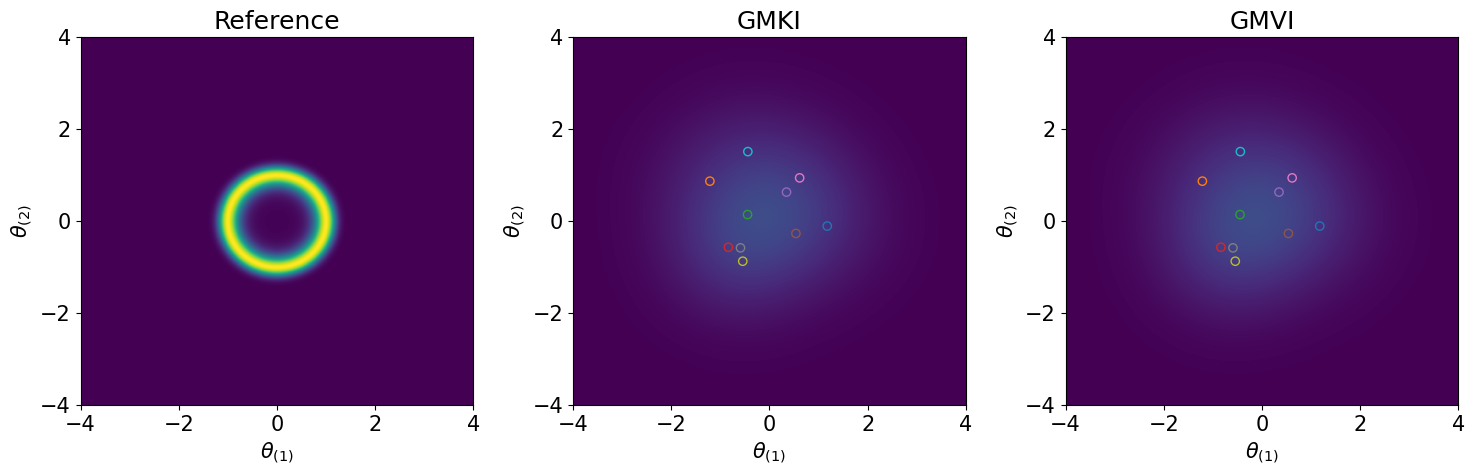

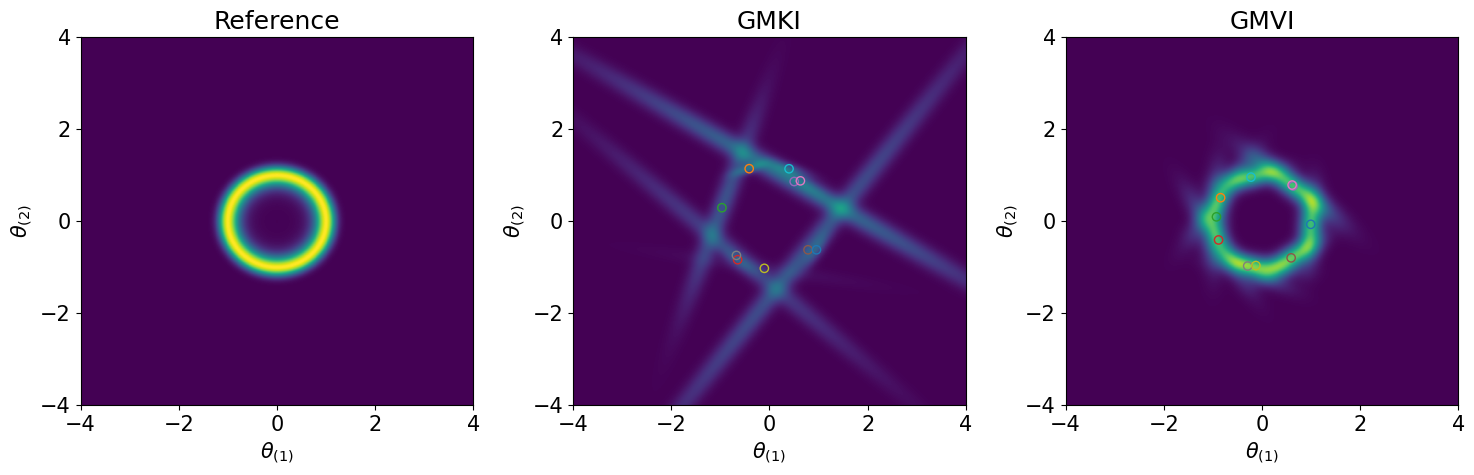

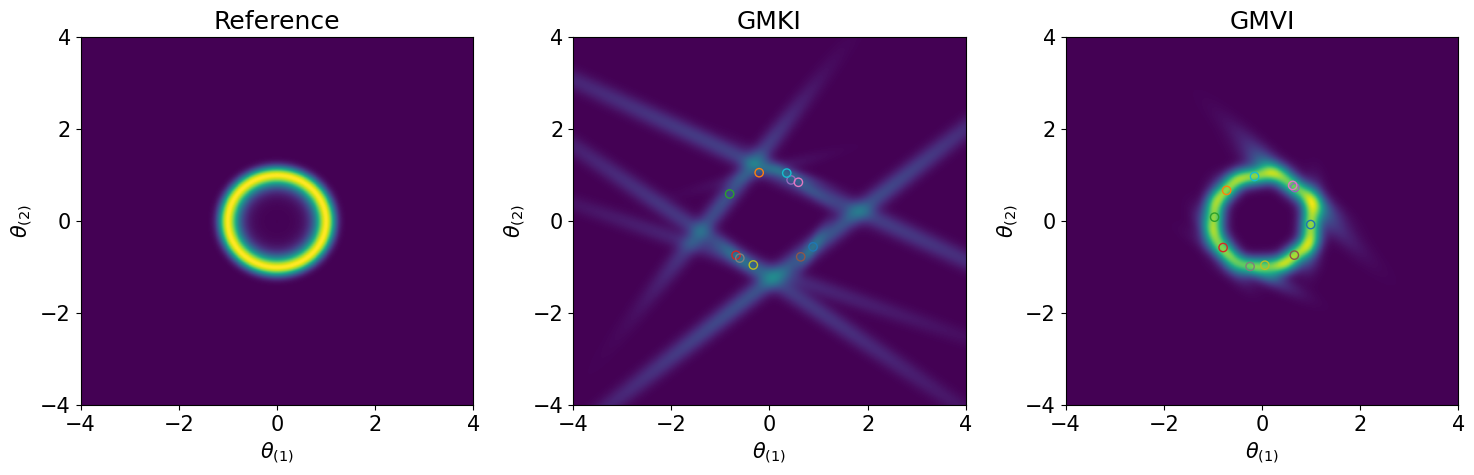

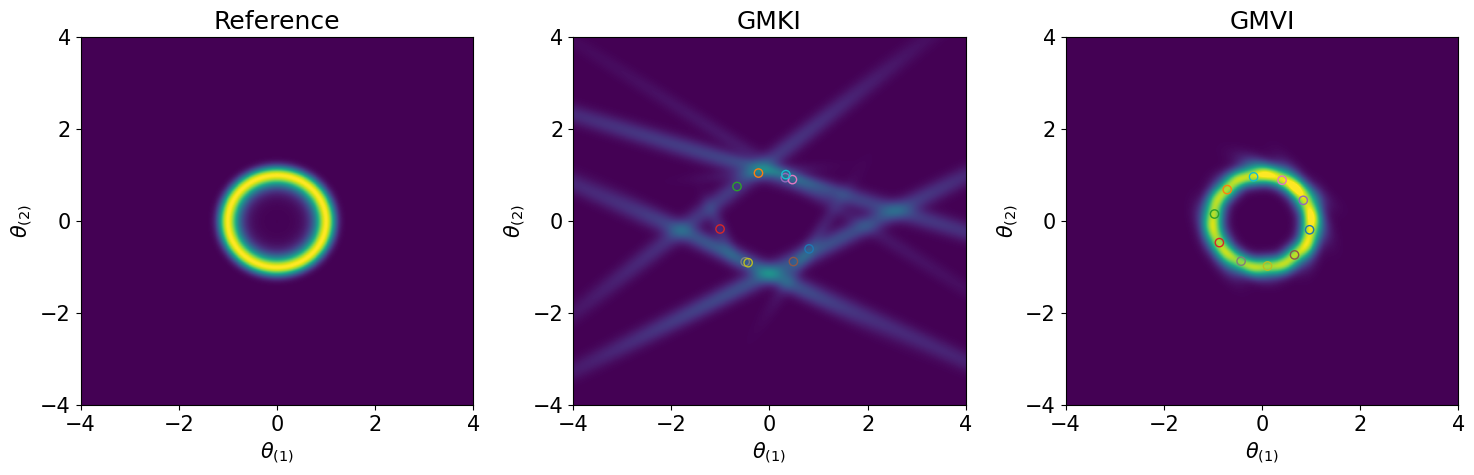

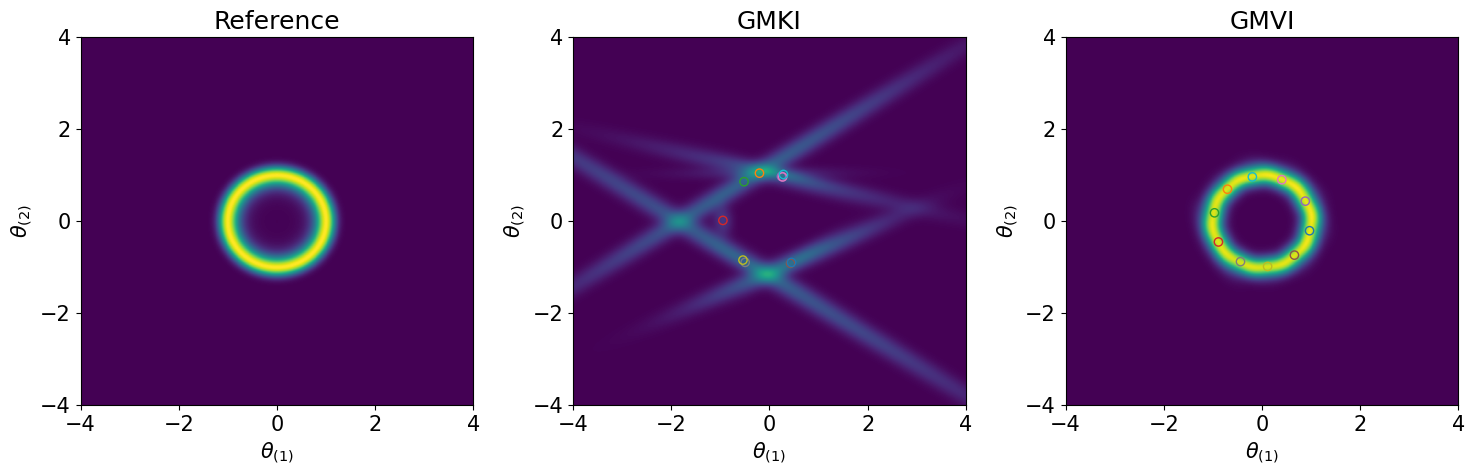

┌ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/GMKI.jl:123
┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /Users/huang/.julia/packages/PyCall/L0fLP/src/numpy.jl:67
┌ Info: ("GMKI L₁ error = ", 1.3654257328342907)
└ @ Main In[4]:182
┌ Info: ("GMGD L₁ error = ", 1.3654257328342907)
└ @ Main In[4]:214
┌ Info: ("GMKI L₁ error = ", 1.4411447562169355)
└ @ Main In[4]:182
┌ Info: ("GMGD L₁ error = ", 0.5072865432284712)
└ @ Main In[4]:214
┌ Info: ("GMKI L₁ error = ", 1.4671212105220752)
└ @ Main In[4]:182
┌ Info: ("GMGD L₁ error = ", 0.3844864298595591)
└ @ Main In[4]:214
┌ Info: ("GMKI L₁ error = ", 1.4800625594095809)
└ @ Main In[4]:182
┌ Info: ("GMGD L₁ error = ", 0.22788809939027385)
└ @ Main In[4]:214
┌ Info: ("GMKI L₁ error = ", 1.428607307711658)
└ @ Main In[4]:182
┌ Info: ("GM

In [5]:
circle_shape([0.0;0.0]; Run_GMKI=true, Run_MCMC=false, Run_Fisher_Rao=false, Run_GMGD=true);

In [6]:
┌ Info: ("y = ", [1.0])
└ @ Main In[18]:13
┌ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/GMKI.jl:124
┌ Info: ("GMKI L₁ error = ", 1.3654257328342907)
└ @ Main In[18]:192
┌ Info: ("GMKI L₁ error = ", 1.4934846125939854)
└ @ Main In[18]:192

LoadError: syntax: extra token "Info" after end of expression